# Introduction to funcional API

 While the sequential API is extremely easy to use, it has some limitations. For example, it is not possible to easily create models that reuse layers in Sequential API. This means that if you want to use the same layer twice, you'll have to create two separate models, using `the model.add(tf.keras.layers.Dense())` method.

 This is where the Functional API, which is more flexible than the Sequential API, comes into the picture. It allows us to build models that are more complex, such as models with multiple input layers or multiple output layers, and also provides the flexibility to reuse layers. The difference between Sequential and Functional API is in how

* the input is defined,

* the layers are connected, and

* the model is created.

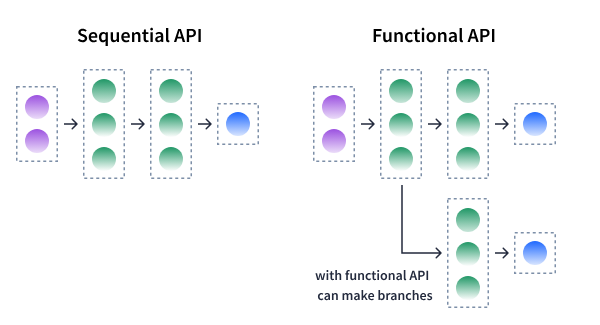

#Loading Data



In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Cleaning Dataset


In [33]:
df = sns.load_dataset('titanic')


df['embark_town'].fillna('Southampton', inplace=True)


print(df['survived'].value_counts())
print(df['alive'].value_counts())
print(df['class'].value_counts())
print(df['pclass'].value_counts())
df['age'].fillna(df['age'].median(), inplace=True)
df = df.drop(['embarked', 'deck', 'alive', 'class'], axis=1)
percent_missing = df.isnull().sum() / len(df) * 100
#print(percent_missing)

survived
0    549
1    342
Name: count, dtype: int64
alive
no     549
yes    342
Name: count, dtype: int64
class
Third     491
First     216
Second    184
Name: count, dtype: int64
pclass
3    491
1    216
2    184
Name: count, dtype: int64


<ipython-input-33-06a0aec481a3>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['embark_town'].fillna('Southampton', inplace=True)
<ipython-input-33-06a0aec481a3>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

#Dummy Creating


In [34]:
df = pd.get_dummies(df, columns=['embark_town'], drop_first=True, prefix='embark_town')


df = pd.get_dummies(df, columns=['sex'], drop_first=True, prefix='sex')
df = pd.get_dummies(df, columns=['adult_male'], drop_first=True, prefix='adult_male')
df = pd.get_dummies(df, columns=['alone'], drop_first=True, prefix='alone')
df = pd.get_dummies(df, columns=['who'], drop_first=True, prefix='who')
df = pd.get_dummies(df, columns=['pclass'], drop_first=True, prefix='pclass')


#Train / Test SET

In [38]:
target_variable = ['survived']
predictors = list(set(list(df.columns)) - set(target_variable))
# Convert all predictor columns to numeric type, coercing errors to NaN
for col in predictors:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute NaN values with the median for numeric columns
# This ensures all your predictor variables are numeric
df[predictors] = df[predictors].fillna(df[predictors].median())
df[predictors] = df[predictors] / df[predictors].max()

X = df[predictors].values
y = df[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)
print(X_train.shape)

(623, 13)


#Defining Model with the Functional API

1. **Define the Input Layer**

Unlike the Sequential model, where the input shape is defined in the first hidden layer itself, the Functional model defines a standalone input layer that specifies the shape of input data. This is shown below:

    import tensorflow as tf
    input_layer = tf.keras.Input(shape=(X_train.shape[1],))

Note that at the end of the above line of code, the shape is passed as a tuple here, not just the number of features in X_train.

2. **Add Hidden Layers**

The next step is defining the hidden layers, which from the Functional API perspective, are comprised of the following:

* specifying the number of nodes
* selecting an activation function
* connecting the incoming layer

This is demonstrated in the code below, where we define the first hidden layer for our model:

    hidden_layer1 = tf.keras.layers.Dense(128, activation='relu')(input_layer)

In `hidden_layer1`, the number of nodes is 128 and `relu` is the activation function. Notice the positioning of `input_layer` in brackets at the end. Bracket notations are used to specify where the input for each layer comes from.

Unlike Sequential API, where we simply stack layers together by calling one layer after the other, Functional API is more flexible, as we can create models with shared layers by making a call to the previous layer as a component of the current layer.

3. **Add Dropout Layer**

This is the perfect time to introduce the concept of a dropout layer, which is a regularization technique for neural networks that helps prevent overfitting. The idea behind a dropout layer is to randomly drop units (either hidden or visible) from the network during training. A unit is a single neuron in a neural network. This has the effect of making the network more resistant to overfitting.

The code below shows how we add the first dropout layer, drop1, after the first hidden layer.

    drop1 = tf.keras.layers.Dropout(rate=0.40)(hidden_layer1)

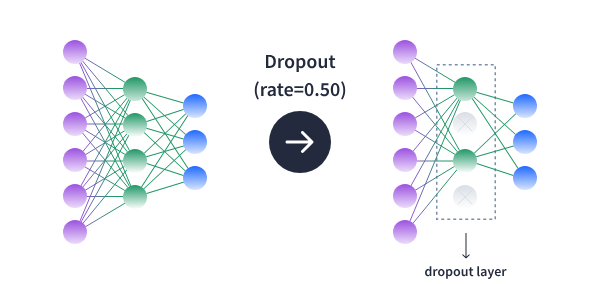

This dropout layer, drop1, will become an input to second hidden layer, hidden_layer2, as shown below:

    hidden_layer2 = tf.keras.layers.Dense(64, activation='relu')(drop1)

This way we can add more hidden and dropout layers with the Functional API. We'll have six hidden layers in our model. The last hidden layer, `output_layer`, of the model is used as the output layer. The last layer is shown below, which is a dense layer with a `sigmoid` activation function.

    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer5)

4. Instatiate the model

Once we've created all the hidden layers, we'll define the model. We'll use the `Model()` class to instantiate a model with the specification of the input and output layers. For example:

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)



In [39]:
input_layer = tf.keras.Input(shape=(X_train.shape[1],))

hidden_layer1 = tf.keras.layers.Dense(128, activation='relu')(input_layer)

drop1 = tf.keras.layers.Dropout(rate=0.40)(hidden_layer1)

hidden_layer2 = tf.keras.layers.Dense(64, activation='relu')(drop1)

drop2 = tf.keras.layers.Dropout(rate=0.20)(hidden_layer2)

hidden_layer3 = tf.keras.layers.Dense(16, activation='relu')(drop2)

hidden_layer4 = tf.keras.layers.Dense(8, activation='relu')(hidden_layer3)

hidden_layer5 = tf.keras.layers.Dense(4, activation='relu')(hidden_layer4)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer5)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

None


#Compile, Fit, and Evaluate the Model

1. **Adam Optimizer**

We'll use the Adam optimizer that we've discussed previously. As a reminder, we can instantiate an Adam optimizer object with the following syntax:

    optimizer = tf.keras.optimizers.Adam(0.001)

The one parameter we passed to the above optimizer is the `learning_rate', which controls how much the weights of the neural network model are updated during training. ou can learn more about optimizers [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).



2. **Loss Function**

Once we've selected the optimizer, we need to select a loss function that we want to optimize. Since we're solving a binary classification algorithm, we can use the binary cross entropy loss function, which is used to compute the loss for a binary classification problem.

We can instantiate this loss function with the following syntax:
    
    loss = tf.keras.losses.BinaryCrossentropy()

You can learn more about loss functions [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

3.  **Metrics**

To measure the performance of a machine learning model, it's important to define an evaluation metric. The accuracy evaluation metric is used to evaluate the performance of a binary classification model. This metric calculates the percentage of correct predictions made by the model. A higher accuracy score indicates that the model is better at making predictions and vice versa.

You can learn more about metrics [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

4. **Fit the Model**

The `fit()` method takes in the training data as well as the number of epochs we want to train for. An epoch is one pass through the training data. For example, after training for 10 epochs, our model will be trained on all of the training data 10 times.

    model.fit(X_train, y_train, epochs=10, verbose=0)

5. **Evaluate the Model**

We've fitted the model on the training set, and the next step is to evaluate the model. This is done with the `evaluate()` method, as shown below:

    model.evaluate(X_train, y_train)

The above code will produce the output that will show model performance on the training dataset.



In [40]:
optimizer = tf.keras.optimizers.Adam(0.001)

loss = tf.keras.losses.BinaryCrossentropy()

metrics = ['accuracy']

#compile
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#Fit
model.fit(X_train, y_train, epochs=10, verbose=0)

#evaluate train set
print(model.evaluate(X_train, y_train))

#evaluate test set
print(model.evaluate(X_test, y_test))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.4357  
[0.4184775948524475, 0.8282504081726074]
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8022 - loss: 0.4554 
[0.4539726972579956, 0.7985074520111084]


#Conclusion

During the course of this lesson, we achieved an accuracy of 82% on the training set and 79% on the test data set. These values indicate that the performance of the model is good.

Also: remember that if the train accuracy is much higher than the test accuracy, it could mean that the model is overfitting on the training data. This means that the model has learned patterns in the training data that do not generalize well to new data. It's important to monitor both train and test accuracy during model development and tune parameters accordingly to avoid **overfitting**.

If you're seeing a large discrepancy between train and test accuracy, it's worth investigating to try to understand why. If the model is overfitting, you may need to use **regularization techniques** to prevent this.